# Spiral Multiclass Classificaiton

## Introduction

This notebook is meant to practice the multi-class classification using `pytorch`.
THe focus here is to generate a non-linear dataset for training and introducing non linearity.

## Data Preparation and Exploration

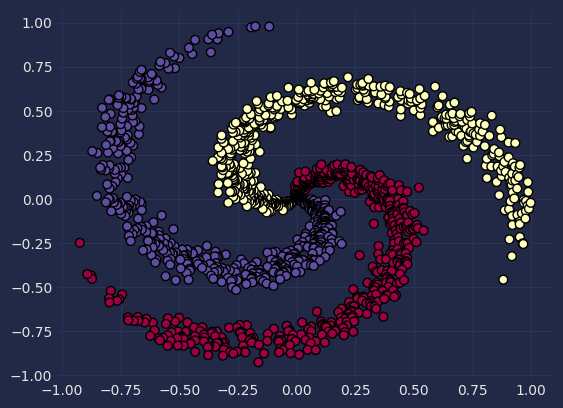

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from utils.datasets import make_spirals

# just for a dark mode graphs, nothing really useful
import mplcyberpunk
plt.style.use('cyberpunk')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

X, y = make_spirals(sample_size=1500)

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='k')
plt.show()

Lets explore the data and see the shapes of X and y.

In [34]:
print(f"Type of X is {type(X)} and it have a shape of {X.shape} and a dtype of {X.dtype}")
print(f"Type of y is {type(y)} and it have s shape of {y.shape} and a dtype of {y.dtype}")

Type of X is <class 'numpy.ndarray'> and it have a shape of (1500, 2) and a dtype of float64
Type of y is <class 'numpy.ndarray'> and it have s shape of (1500,) and a dtype of uint8


Now since we need to use pytorch for building and training a model, we need to do the following to our data:
1. Split the data for training and testings sets.
2. Change the type of our datasets to `torch.Tensor` as the are currenty `numpy.ndarray`
3. Change the `dtype` of the X from `float64` to `float32`.
4. Change the `dtype` of the y from `uint8` to `TensorLong`. This is necessary for the loss function later, as it expects `TensorLong`

In [35]:
from sklearn.model_selection import train_test_split
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"using device: {device}\n")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

# we are going to inspect the shapes of the train and test data to ensure everything is as expected.
print(f"Shapes of training data split are: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Shapes of testing data split are: X_train={X_test.shape}, y_train={y_test.shape}")

# now we convert the types and dtypes and use device agnostic code so later this code can run on GPU or CPU
X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device)

using device: cpu

Shapes of training data split are: X_train=(1125, 2), y_train=(1125,)
Shapes of testing data split are: X_train=(375, 2), y_train=(375,)


## Buildig and Training a Neural Network
Next we need to build a Neural Network using pyTorch to fit into the data and find the ability to predict the class of each point.

The following should be done:
1. Create a Model by extending the `nn.Module` from pytorch.
2. Plot the decision boundary of the untrained model.
3. Create a train and testing loop and observe the model learning
4. Plot the decision boundary of the trained model

### Building the Neural Netowrk

From the above plot of the data, it seems very obvious a simple linear layer will not be able to learn.

So, a non linear activation function will be used after each linear layer, typically `ReLu` here after each linear layer.

In [36]:
from torch import nn

class SpiralClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 4)
        )
    def forward(self, x):
        return self.seq(x)

### Plot the decision boundary for the Untrained model

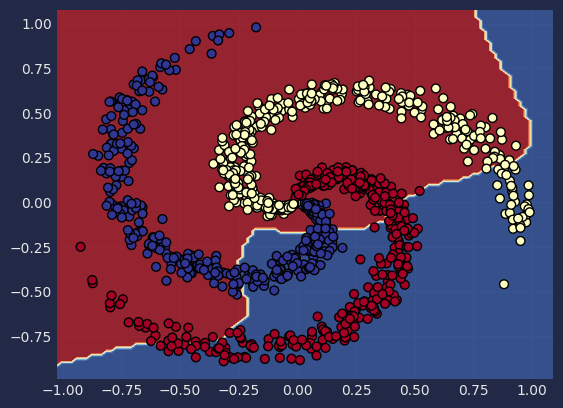

In [50]:
from utils.boundaries import plot_decision_boundary

# instantiate the model with random weights and bais
model = SpiralClassificationModel().to(device)

# plot the decision boundary
plot_decision_boundary(model, X_train, y_train)


### Train the Neural Network

Its time to pick a loss function, optimizer and prepare the accuracy function. The choices will be as follows:

1. For the **Optimizer** we will use `Adam`
2. For the **Loss Function** we will be using `CrossEntropyLoss` because we the problem is multi class classification.
3. For the **Metrics** we will use an `Accuracy` function from `torchmetrics` library.

In [51]:
from torchmetrics import Accuracy

# Prepare the metrics and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task='multiclass', num_classes=4)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# Building the training and testing loop
epochs = 100

for epoch in range(epochs):
    # set the model into the training mode
    model.train()
    
    # run the forward path to calculate the output logits
    y_logits = model(X_train).squeeze()
    
    # convert the output logits to preds and label for calculating the accuracy
    y_preds = torch.softmax(y_logits, dim=1)
    y_labels = torch.argmax(y_preds, dim=1)

    # calculate the metrics (loss and accuracy)
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_labels, y_train)

    # configure the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # set the model into the eval() for testing
    model.eval()

    with torch.inference_mode():
        y_logits_test = model(X_test).squeeze()
        y_preds_test = torch.softmax(y_logits_test, dim=1)
        y_labels_test = torch.argmax(y_preds_test, dim=1)

        test_loss = loss_fn(y_logits_test, y_test)
        test_acc = acc_fn(y_labels_test, y_test)

    # print out the metrics every n epoch
    if epoch % 10 == 0:
        print(f"epoch: {epoch}, loss: {loss:0.4f}, acc: {acc * 100:0.2f} | test_loss: {test_loss:0.4f}, test_acc: {test_acc * 100:0.2f}")


epoch: 0, loss: 1.4628, acc: 23.47 | test_loss: 1.3887, test_acc: 36.00
epoch: 10, loss: 0.9874, acc: 57.69 | test_loss: 0.9751, test_acc: 57.07
epoch: 20, loss: 0.7251, acc: 60.89 | test_loss: 0.7624, test_acc: 58.67
epoch: 30, loss: 0.5958, acc: 64.62 | test_loss: 0.6217, test_acc: 64.00
epoch: 40, loss: 0.4618, acc: 74.93 | test_loss: 0.4704, test_acc: 76.27
epoch: 50, loss: 0.3355, acc: 85.16 | test_loss: 0.3368, test_acc: 85.07
epoch: 60, loss: 0.2387, acc: 90.58 | test_loss: 0.2289, test_acc: 90.13
epoch: 70, loss: 0.1757, acc: 93.60 | test_loss: 0.1610, test_acc: 94.40
epoch: 80, loss: 0.1354, acc: 95.82 | test_loss: 0.1189, test_acc: 96.53
epoch: 90, loss: 0.1077, acc: 97.16 | test_loss: 0.0896, test_acc: 97.87


### Plot Decision Boundary for the Trained Model

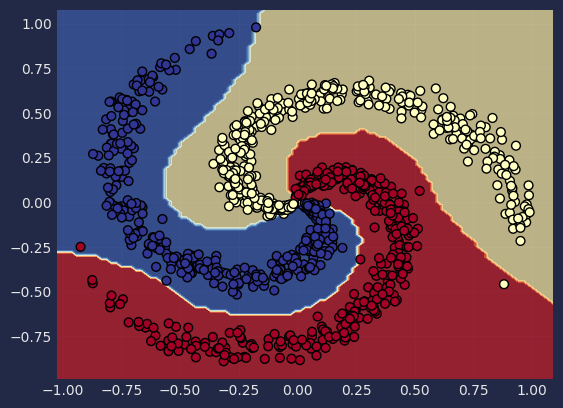

In [52]:
plot_decision_boundary(model, X_train, y_train)